In [252]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [253]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The code for this notebook is hidden for easier reading.
To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

# Questions for Debjit: 

<span class="burk">1.  Why did the initial data preparation drill suggest that 'murder' and 'robbery' be recoded as categorical features? Does this choice impact the assumptions and model outcomes?
<span class="burk">2.  Are all 4 assumptions equally weighted? If not, which are prioritized and why? Must I always attempt to fix violated assumptions and if so, how far can I go before I'm over-engineering features?</span> 
<span class="burk">3.  When evaluating a model using holdout groups and/or cross-validation, should I check assumptions for the testing dataset as well? Why or why not?</span></span> 

# Cleaning & Feature Engineering

**Data: Crime In New York - [2013](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv).**

**I created a dataframe to hold the following features and the target variable - property crime:** 
-  'population' (Continuous)
-  'population_squared' (Continuous)
-  'murder' (Categorical)
-  'robbery' (Categorical)

In [254]:
path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime = pd.read_csv(path)

In [255]:
pd.options.mode.chained_assignment = None

crime.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']
crime.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)

pcmodel = crime[['murder','population','property_crime','robbery']]
columns = list(pcmodel.columns)
for column in columns:
    pcmodel[column]=pcmodel[column].str.replace(',','')
pcmodel = pcmodel.apply(pd.to_numeric)

pcmodel['population_squared']=pcmodel['population']**2
pcmodel['murder']=pcmodel['murder'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
pcmodel['robbery']=pcmodel['robbery'].apply(lambda x: 0 if x <= 0 else 1).astype('int64')
pcmodel.dropna(axis=0,how='all',inplace=True)
pcmodel.head()

,murder,population,property_crime,robbery,population_squared
4,0,1861,12,0,3463321
5,0,2577,24,0,6640929
6,0,2846,16,0,8099716
7,1,97956,4090,1,9595377936
8,0,6388,223,1,40806544


In [256]:
pcmodel.describe()

,murder,population,property_crime,robbery,population_squared
count,348.000000,3.480000e+02,348.000000,348.000000,3.480000e+02
mean,0.140805,4.003763e+04,792.606322,0.600575,2.035547e+11
std,0.348321,4.500374e+05,7659.724746,0.490486,3.778876e+12
min,0.000000,5.260000e+02,0.000000,0.000000,2.766760e+05
25%,0.000000,3.003000e+03,40.500000,0.000000,9.018117e+06
50%,0.000000,7.233500e+03,112.500000,1.000000,5.232568e+07
75%,0.000000,1.842750e+04,341.000000,1.000000,3.397536e+08
max,1.000000,8.396126e+06,141971.000000,1.000000,7.049493e+13


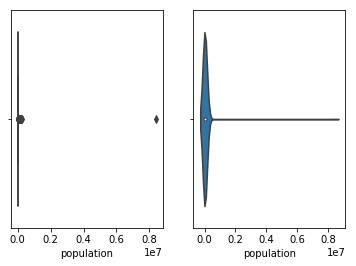

In [257]:
plt.subplot(121)
population = sns.boxplot(pcmodel['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel['population'])

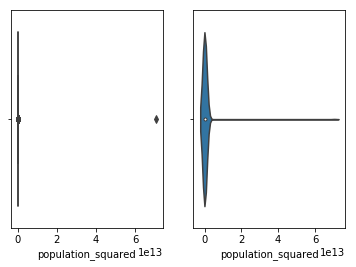

In [258]:
plt.subplot(121)
population_squared = sns.boxplot(pcmodel['population_squared'])
plt.subplot(122)
population = sns.violinplot(pcmodel['population_squared'])

**There are extreme outliers (much more densely populated cities) beyond Q3+1.5IQR that I chose to exclude.**

In [259]:
columns = list(pcmodel[['population','population_squared']].columns)
for column in columns: 
    q25 = pcmodel[column].quantile(0.25)
    q75 = pcmodel[column].quantile(0.75)
    iqr = q75 - q25
    max = q75 + (iqr * 1.5)
    pcmodel=pcmodel.where(pcmodel[column] < max)

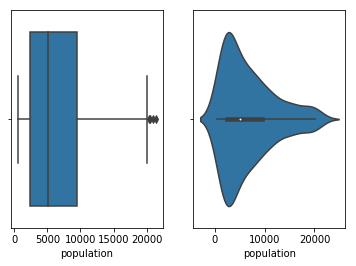

In [260]:
plt.subplot(121)
population = sns.boxplot(pcmodel['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel['population'])

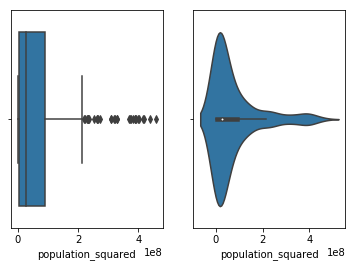

In [261]:
plt.subplot(121)
population_squared = sns.boxplot(pcmodel['population_squared'])
plt.subplot(122)
population_squared = sns.violinplot(pcmodel['population_squared'])

In [262]:
pcmodel.describe()

,murder,population,property_crime,robbery,population_squared
count,274.000000,274.000000,274.000000,274.000000,2.740000e+02
mean,0.051095,6730.492701,130.014599,0.500000,7.301594e+07
std,0.220594,5274.271168,151.249060,0.500915,1.039372e+08
min,0.000000,526.000000,0.000000,0.000000,2.766760e+05
25%,0.000000,2467.750000,31.000000,0.000000,6.089970e+06
50%,0.000000,5133.500000,73.500000,0.500000,2.635293e+07
75%,0.000000,9517.000000,171.000000,1.000000,9.057329e+07
max,1.000000,21397.000000,949.000000,1.000000,4.578316e+08


# Initial Model

In [263]:
pcmodel = pcmodel.dropna()
Y1 = pcmodel['property_crime']
X1 = pcmodel[['murder','population','population_squared','robbery']]

In [264]:
regr = linear_model.LinearRegression()
regr.fit(X1, Y1)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X1, Y1))


Coefficients: 
 [6.76296273e+01 1.18902035e-02 1.52184341e-07 9.04003946e+01]

Intercept: 
 -9.779938071912653

R-Squared:
0.5405511190673918


In [265]:
lf = 'property_crime ~ population + population_squared + murder + robbery'
lm = smf.ols(formula=lf, data=pcmodel).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     79.12
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           2.74e-44
Time:                        18:59:53   Log-Likelihood:                -1656.9
No. Observations:                 274   AIC:                             3324.
Df Residuals:                     269   BIC:                             3342.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -9.7799     15

**Based on the overall model's F-test statistic and p-value, I concluded that it provides a better fit than the intercept-only model.**

**Based on the features' t-test statistics and p-values, 'population_squared' isn't a statistically significant feature of the model.** 

**Based on the warning citing "multicollinearity or other numerical problems", I decided to check all 4 assumptions before making feature engineering and model revision decisions.** 

# Checking Assumptions

## Linear Relationship

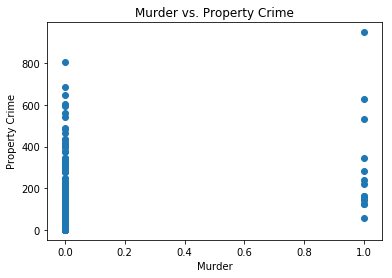

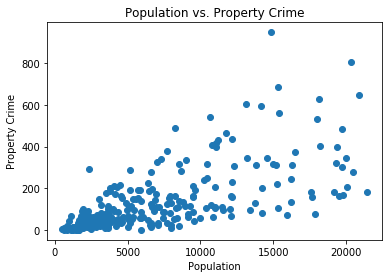

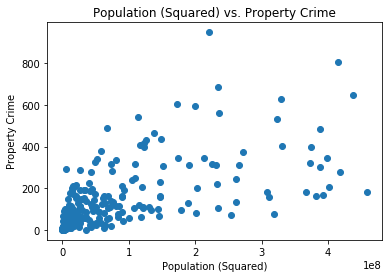

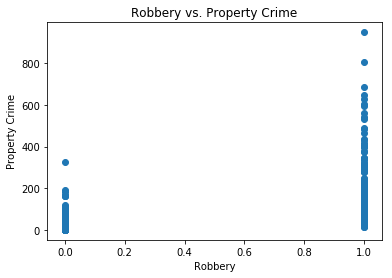

In [266]:
plt.scatter(y=pcmodel['property_crime'], x=pcmodel['murder'])
plt.ylabel('Property Crime')
plt.xlabel('Murder')
plt.title('Murder vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population_squared'])
plt.ylabel('Property Crime')
plt.xlabel('Population (Squared)')
plt.title('Population (Squared) vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

**The target 'property crime' seems to be less related to the features 'murder' and 'population_squared'.**

## Multivariate Normality

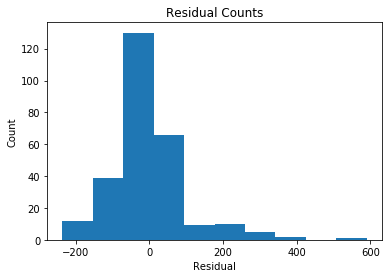

In [267]:
predicted = regr.predict(X1).ravel()
actual = Y1
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The model's error is approximately normal.**

## Homoscedasticity

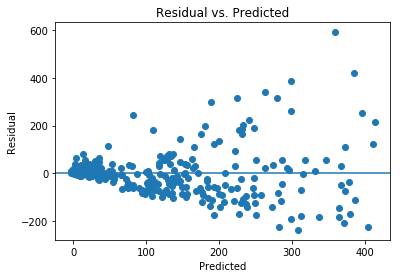

In [268]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**The error terms are heteroscedastic.**

## Low Multicollinearity

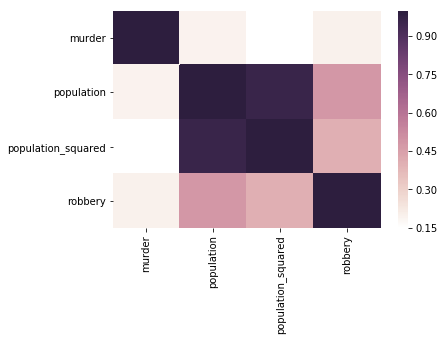

In [269]:
correlation_matrix = X1.corr()
multicollinearity = sns.heatmap(correlation_matrix,cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**Consistent with the initial model's warning, the feature 'population and its derivative 'population_squared' are highly correlated.**

# Feature Reengineering

**Decisions:**
-  Added 'burglary' hypothesizing that it might improve the model's coefficient of determination (R^2). 
-  Added 'larceny_theft' hypothesizing that it might improve the model's coefficient of determination (R^2). 
-  Added 'vehicle_theft' hypothesizing that it might improve the model's coefficient of determination (R^2). 
-  Dropped 'population_squared' based on the initial model's summary statistics (p-value). 

In [270]:
pcmodel[['burglary','larceny_theft','vehicle_theft']]=crime[['burglary','larceny_theft','vehicle_theft']]
pcmodel.drop(labels=['population_squared'], axis=1, inplace=True)

In [271]:

pcmodel.dropna(axis=0,how='all',inplace=True)
pcmodel = pcmodel.apply(pd.to_numeric)
pcmodel['burglary']=pcmodel['burglary'].apply(lambda x: 0 if x <= 0 else 1)
pcmodel['larceny_theft']=pcmodel['larceny_theft'].apply(lambda x: 0 if x <= 0 else 1)
pcmodel['vehicle_theft']=pcmodel['vehicle_theft'].apply(lambda x: 0 if x <= 0 else 1)
pcmodel.head()

,murder,population,property_crime,robbery,burglary,larceny_theft,vehicle_theft
4,0.0,1861.0,12.0,0.0,1,1,0
5,0.0,2577.0,24.0,0.0,1,1,1
6,0.0,2846.0,16.0,0.0,1,1,0
8,0.0,6388.0,223.0,1.0,1,1,1
9,0.0,4089.0,46.0,1.0,1,1,0


# Revised Model 

In [272]:
Y2 = pcmodel['property_crime']
X2 = pcmodel[['burglary','larceny_theft','murder','population','robbery','vehicle_theft']]

In [273]:
regr = linear_model.LinearRegression()
regr.fit(X2, Y2)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X2, Y2))


Coefficients: 
 [-2.39429147e+00 -3.33990134e+00  6.43939850e+01  1.45860406e-02
  8.50177741e+01  1.49947933e+01]

Intercept: 
 -18.395688944312752

R-Squared:
0.5414587647094049


In [274]:
lf2 = 'property_crime ~ burglary + larceny_theft + murder + population + robbery + vehicle_theft'
lm2 = smf.ols(formula=lf2, data=pcmodel).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     52.55
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           1.68e-42
Time:                        18:59:55   Log-Likelihood:                -1656.7
No. Observations:                 274   AIC:                             3327.
Df Residuals:                     267   BIC:                             3353.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -18.3957     39.368     -0.467

**The model's coefficient of determination (R^2) but is more or less the same as the initial model's according to the above regression score and summary.**

**Based on the revised overall model's F-test statistic and p-value, I concluded that it still provides a better fit than the intercept-only model.**

**Based on the features' t-test statistics and p-values, 'burglary', 'larceny_theft', and 'vehicle_theft' aren't statistically significant features of the model.** 

**Based on the warning citing "multicollinearity or other numerical problems", I decided to re-check all 4 assumptions before making final feature engineering and model revision decisions.** 

# Re-Checking Assumptions

## Linear Relationship

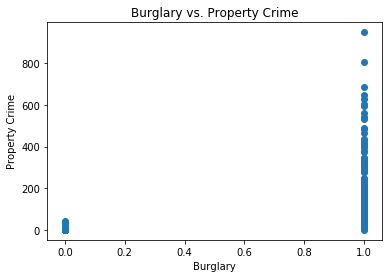

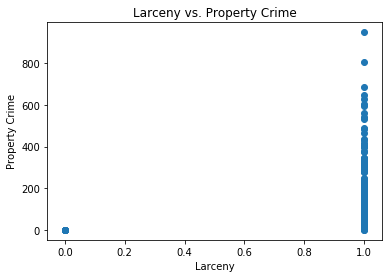

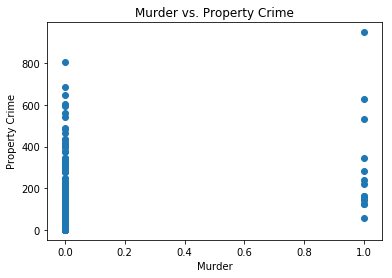

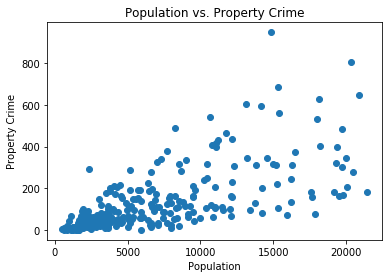

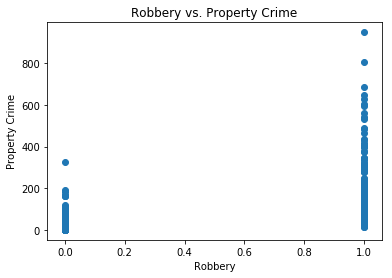

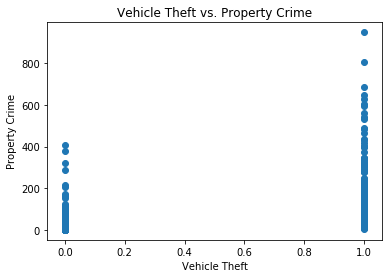

In [275]:
plt.scatter(y=pcmodel['property_crime'], x=pcmodel['burglary'])
plt.ylabel('Property Crime')
plt.xlabel('Burglary')
plt.title('Burglary vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['larceny_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Larceny')
plt.title('Larceny vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['murder'])
plt.ylabel('Property Crime')
plt.xlabel('Murder')
plt.title('Murder vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['vehicle_theft'])
plt.ylabel('Property Crime')
plt.xlabel('Vehicle Theft')
plt.title('Vehicle Theft vs. Property Crime')
plt.show()

**There are linear relationship between these features and the target, but 'murder' seems to be less linearly related than 'burglary', 'larceny_theft', 'population, 'robbbery', and 'vehicle_theft' are to 'property_crime'.**

## Multivariate Normality

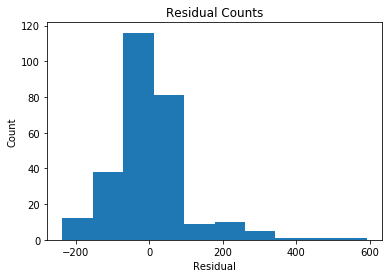

In [276]:
predicted = regr.predict(X2).ravel()
actual = Y2
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The model's error is still approximately normally distributed.**

## Homoscedasticity

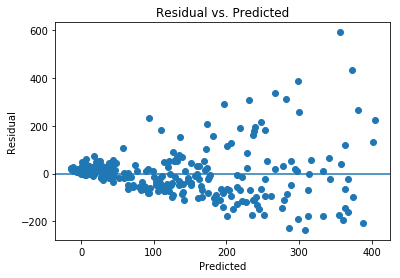

In [277]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**The error terms are still heteroscedastic.**

## Low Multicollinearity 

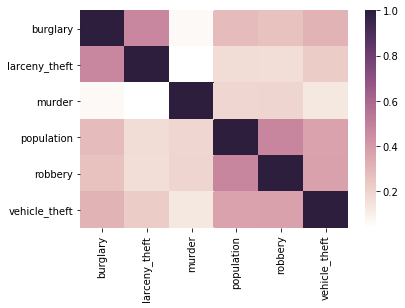

In [280]:
correlation_matrix = X2.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**There are moderate interactions between 'burglary' and larceny_theft' and 'population' and 'robbery'.**

# Final Model 

## Feature Finalization

**Decisions:**
-  Dropped 'burglary' based on the revised model's summary statistics (p-value). 
-  Dropped 'larceny_theft' based on the revised model's summary statistics (p-value). 
-  Dropped 'vehicle_theft' based on the revised model's summary statistics (p-value). 

**Final Feature Set:**
-  'murder'
-  'population'
-  'robbery'

In [281]:
pcmodel = pcmodel[['murder','population','property_crime','robbery']]
pcmodel.head()

,murder,population,property_crime,robbery
4,0.0,1861.0,12.0,0.0
5,0.0,2577.0,24.0,0.0
6,0.0,2846.0,16.0,0.0
8,0.0,6388.0,223.0,1.0
9,0.0,4089.0,46.0,1.0


In [282]:
Y3 = pcmodel['property_crime']
X3 = pcmodel[['murder','population','robbery']]

In [283]:
regr = linear_model.LinearRegression()
regr.fit(X3, Y3)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X3, Y3))


Coefficients: 
 [6.55050065e+01 1.48837035e-02 8.82772660e+01]

Intercept: 
 -17.645663626959788

R-Squared:
0.539750001692379


In [284]:
lf3 = 'property_crime ~ murder + population + robbery'
lm3 = smf.ols(formula=lf3, data=pcmodel).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     105.5
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           3.09e-45
Time:                        18:59:57   Log-Likelihood:                -1657.2
No. Observations:                 274   AIC:                             3322.
Df Residuals:                     270   BIC:                             3337.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.6457     10.492     -1.682      0.0

## Final Assumptions Check 

### Linear Relationship

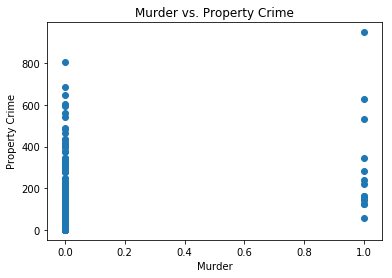

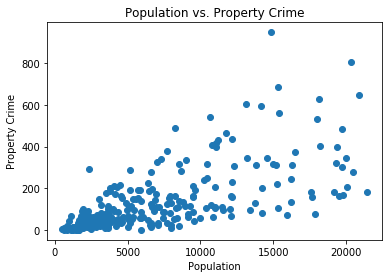

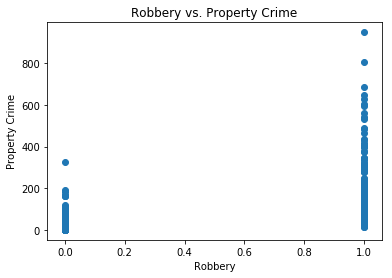

In [285]:
plt.scatter(y=pcmodel['property_crime'], x=pcmodel['murder'])
plt.ylabel('Property Crime')
plt.xlabel('Murder')
plt.title('Murder vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['population'])
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=pcmodel['property_crime'], x=pcmodel['robbery'])
plt.ylabel('Property Crime')
plt.xlabel('Robbery')
plt.title('Robbery vs. Property Crime')
plt.show()

**There's still a linear relationship between these features and the target, and 'murder' still seems to be less linearly related than the others.**

### Multivariate Normality

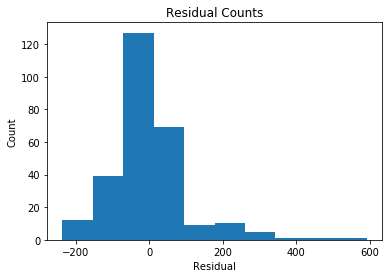

In [286]:
predicted = regr.predict(X3).ravel()
actual = Y3
residual = actual - predicted

plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The model's error is still approximately normally distributed.**

### Homoscedasticity

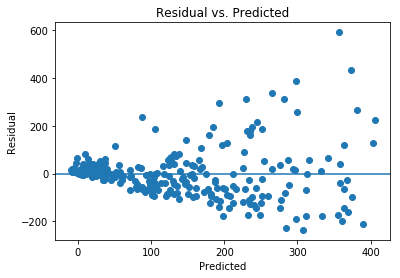

In [287]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**The error terms are still heteroscedastic.**

### Low Multicollinearity

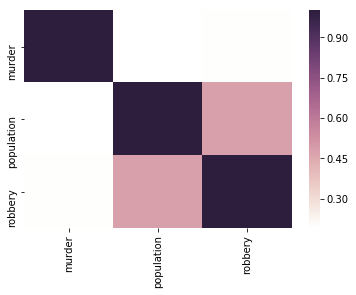

In [288]:
correlation_matrix = X3.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**There's still moderate collinearity between 'population' and 'robbery', but 'murder' isn't correlated with either feature.**

# Model Evaluation: Out-of-Sample

**Data: Crime In New York - [2014](https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls/output.xls).**

**Because my finalized model uses 'murder', 'population', and 'robbery' to explain 'property_crime', I've used the same features to test out-of-sample prediction of the target.** 

## Cleaning

In [307]:
path = 'C:/Users/missn/Documents/Thinkful/CSV Datasets/Unit 2/Unit 2 Lesson 4/Regression NYC Crime Prediction/NYC Crime 2014.csv'
crime_validation = pd.read_csv('C:/Users/missn/Documents/Thinkful/CSV Datasets/Unit 2/Unit 2 Lesson 4/Regression NYC Crime Prediction/NYC Crime 2014.csv')

In [308]:
pd.options.mode.chained_assignment = None

crime_validation.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson','unknown']
crime_validation.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
pcmodel_validation = crime_validation[['murder','population','property_crime','robbery']]

columns = list(pcmodel_validation.columns)
for column in columns:
    pcmodel_validation[column]=pcmodel_validation[column].str.replace(',','')

features = columns[:1]+columns[3:]
for feature in features:
    pcmodel_validation = pcmodel_validation.apply(pd.to_numeric)
    pcmodel_validation[feature]=pcmodel_validation[feature].apply(lambda x: 0 if x <= 0 else 1).astype('int64')

pcmodel_validation = pcmodel_validation.dropna()
pcmodel_validation.head()

,murder,population,property_crime,robbery
4,0,1851.0,11.0,0
5,0,2568.0,49.0,1
6,0,820.0,1.0,0
7,0,2842.0,17.0,0
8,1,98595.0,3888.0,1


In [310]:
pcmodel_validation.describe()

,murder,population,property_crime,robbery
count,365.000000,3.650000e+02,365.000000,365.000000
mean,0.139726,3.808991e+04,699.723288,0.528767
std,0.347178,4.435674e+05,7152.724513,0.499857
min,0.000000,7.900000e+01,0.000000,0.000000
25%,0.000000,2.631000e+03,25.000000,0.000000
50%,0.000000,6.548000e+03,75.000000,1.000000
75%,0.000000,1.540800e+04,270.000000,1.000000
max,1.000000,8.473938e+06,135747.000000,1.000000


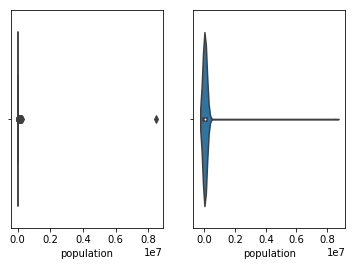

In [311]:
plt.subplot(121)
population = sns.boxplot(pcmodel_validation['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel_validation['population'])

**There are extreme outliers (much more densely populated cities) beyond Q3+1.5IQR that I chose to exclude.**

In [312]:
q25 = pcmodel_validation['population'].quantile(0.25)
q75 = pcmodel_validation['population'].quantile(0.75)
iqr = q75 - q25
max = q75 + (iqr * 1.5)
pcmodel_validation=pcmodel_validation.where(pcmodel_validation['population'] < max)

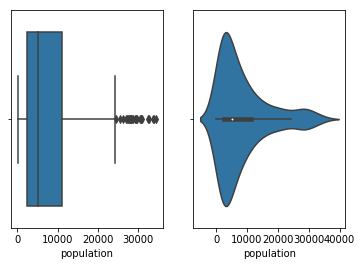

In [313]:
plt.subplot(121)
population = sns.boxplot(pcmodel_validation['population'])
plt.subplot(122)
population = sns.violinplot(pcmodel_validation['population'])

In [314]:
pcmodel_validation.describe()

,murder,population,property_crime,robbery
count,329.000000,329.000000,329.000000,329.000000
mean,0.085106,8481.495441,147.364742,0.480243
std,0.279465,8258.540029,213.732938,0.500371
min,0.000000,79.000000,0.000000,0.000000
25%,0.000000,2460.000000,21.000000,0.000000
50%,0.000000,5234.000000,61.000000,0.000000
75%,0.000000,11231.000000,169.000000,1.000000
max,1.000000,34463.000000,1401.000000,1.000000


## Cross-Validation

In [315]:
lfv = 'property_crime ~ murder + population + robbery'
lmv = smf.ols(formula=lfv, data=pcmodel_validation).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     105.5
Date:                Sun, 25 Feb 2018   Prob (F-statistic):           3.09e-45
Time:                        19:55:34   Log-Likelihood:                -1657.2
No. Observations:                 274   AIC:                             3322.
Df Residuals:                     270   BIC:                             3337.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -17.6457     10.492     -1.682      0.0

**The overall model is more valuable that the intercept-only fit, all of the features are statistically significant, and the R^2 is stable.**